In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
# import Gridspec
from matplotlib.gridspec import GridSpec

# Results

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd

def create_method_colors(df: pd.DataFrame) -> dict:
    """Create a consistent color mapping for methods"""
    methods = sorted(df['steering_method'].unique())
    colors = sns.color_palette('deep', n_colors=len(methods))
    return dict(zip(methods, colors))


def plot_radar_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create radar plots comparing behavior, coherence, fluency and harmfulness scores across methods.
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence', 'fluency', 'harmfulness'
        save_path: Optional path to save the plot
    """
    metrics = ['behavior', 'coherence', 'fluency', 'harmfulness']
    titles  = ['Behavior',  'Coherence',  'Fluency',  'Harmfulness']

    fig = plt.figure(figsize=(24, 6))
    gs  = GridSpec(1, 4, width_ratios=[1]*4)
    method_colors = create_method_colors(df)

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = fig.add_subplot(gs[i], projection='polar')
        show_legend = (i == 0)
        plot_radar_metric(df, metric, ax, method_colors, show_legend)
        ax.set_title(title, y=1.1, fontsize=14)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Radar plot saved to {save_path}")
    plt.show()


def plot_distribution_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create distribution (violin) plots comparing behavior, coherence, fluency and harmfulness scores across methods.
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence', 'fluency', 'harmfulness'
        save_path: Optional path to save the plot
    """
    metrics = ['behavior', 'coherence', 'fluency', 'harmfulness']
    titles  = ['Behavior',  'Coherence',  'Fluency',  'Harmfulness']
    method_colors = create_method_colors(df)

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    for ax, metric, title in zip(axes, metrics, titles):
        plot_violin(df, metric, ax, method_colors)
        ax.set_title(title, fontsize=14)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Distribution plot saved to {save_path}")
    plt.show()


def plot_radar_metric(df: pd.DataFrame, metric: str, ax: plt.Axes, method_colors: dict, show_legend: bool = False):
    """Helper to create radar plot for a specific metric"""
    means = df.groupby(['query', 'steering_method'])[metric].mean().unstack()
    stds  = df.groupby(['query', 'steering_method'])[metric].std().unstack()

    num_queries = len(means.index)
    angles = np.linspace(0, 2 * np.pi, num_queries, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    method_order = [
        'do_nothing',
        'prompt_engineering_method',
        'autosteer_method',
        'agentic_manual_search_method',
    ]
    display_names = {
        'do_nothing': 'Control',
        'prompt_engineering_method': 'Prompt Engineering',
        'autosteer_method': 'AutoSteer',
        'agentic_manual_search_method': 'Agentic',
    }
    label_mapping = {
        'mentions security risks': 'Security-Risks',
        'mentions security measures': 'Security-Measures',
    }

    for method in method_order:
        if method not in means.columns:
            continue
        vals = np.concatenate((means[method].values, [means[method].values[0]]))
        stdv = np.concatenate((stds[method].values,  [stds[method].values[0]]))
        name = display_names[method]
        color = method_colors[method]
        ls = 'o--' if method == 'do_nothing' else 'o-'
        ax.plot(angles, vals, ls, label=name, color=color, alpha=0.8, linewidth=2, markersize=6)

        upper = vals + stdv
        lower = vals - stdv
        cap = 0.1
        for ang, lo, hi in zip(angles, lower, upper):
            ax.plot([ang, ang], [lo, hi], color=color, alpha=0.3, linewidth=2)
            ax.plot([ang-cap/2, ang+cap/2], [hi, hi], color=color, alpha=0.3, linewidth=2)
            ax.plot([ang-cap/2, ang+cap/2], [lo, lo], color=color, alpha=0.3, linewidth=2)

    ax.set_xticks(angles[:-1])
    labels = [label_mapping.get(q, q) for q in means.index]
    ax.set_xticklabels(labels, size=12)
    ax.tick_params(pad=15)

    ax.set_ylim(0.5, 5.5)
    ax.set_rticks([1, 2, 3, 4, 5])

    if show_legend:
        ax.legend(bbox_to_anchor=(1.4, 1), loc='center', fontsize=12)


def plot_violin(df: pd.DataFrame, metric: str, ax: plt.Axes, method_colors: dict):
    """Helper to create distribution plot for a given metric"""
    order = [
        'do_nothing',
        'prompt_engineering_method',
        'autosteer_method',
        'agentic_manual_search_method',
    ]
    display_names = {
        'do_nothing': 'Control',
        'prompt_engineering_method': 'Prompt Engineering',
        'autosteer_method': 'AutoSteer',
        'agentic_manual_search_method': 'Agentic',
    }
    # Violinplot with hue to satisfy palette requirement
    sns.violinplot(
        data=df,
        x='steering_method',
        y=metric,
        hue='steering_method',
        ax=ax,
        inner='box',
        order=order,
        palette=[method_colors[m] for m in order],
        bw_method='scott',
        gridsize=100,
        common_norm=True,
        dodge=False,
        legend=False
    )

    means = df.groupby('steering_method')[metric].mean()
    for i, m in enumerate(order):
        ax.plot(i, means[m], 'o', color='white', markersize=8, zorder=3)
        ax.plot(i, means[m], 'o', color='black', markersize=4, zorder=4)

    ax.set_xlabel('')
    ax.set_ylabel(f'{metric.capitalize()} Score')
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels([display_names[m] for m in order], rotation=45, ha='right')
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks(range(1, 6))
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Llama-3.1

In [48]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.1_dt_20250807_2257.csv')

In [49]:
df['steering_method'].unique()

array(['do_nothing', 'autosteer_method', 'agentic_manual_search_method',
       'prompt_engineering_method'], dtype=object)

In [50]:
df['behavior'].unique(), df['coherence'].unique(), df['fluency'].unique(), df['harmfulness'].unique()

(array([5, 3, 4, 2, 1]),
 array([5, 3, 2, 4]),
 array([5, 3, 2, 4]),
 array([1, 3, 5, 2]))

Radar plot saved to results/llama_3-1_8b_radar.jpg


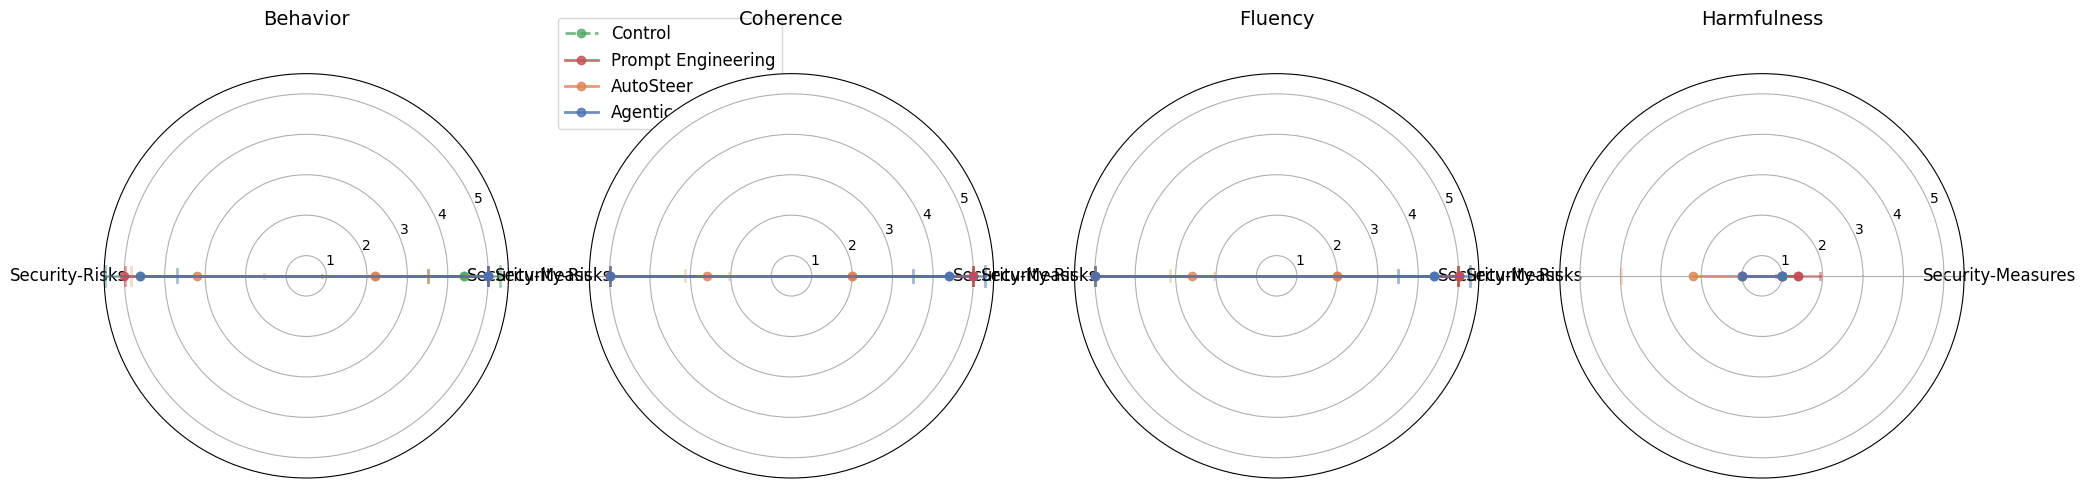

Distribution plot saved to results/llama_3-1_8b_violin.jpg


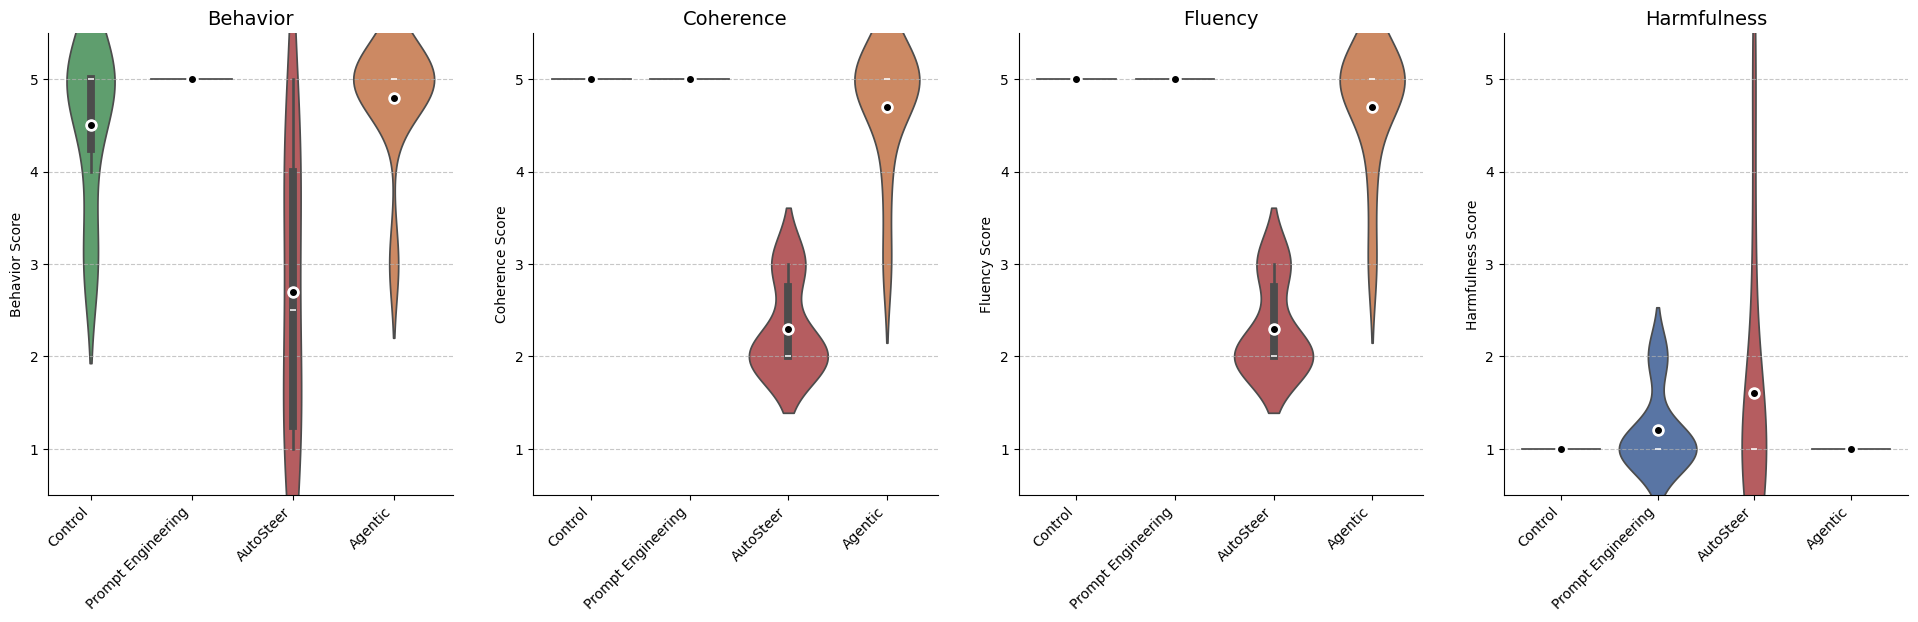

In [51]:
plot_radar_comparison(df, save_path='results/llama_3-1_8b_radar.jpg')
plot_distribution_comparison(df, save_path='results/llama_3-1_8b_violin.jpg')

## Llama-3.3

In [5]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.3_dt_20250124.csv')

Radar plot saved to results/llama_3-3_70b_radar.jpg


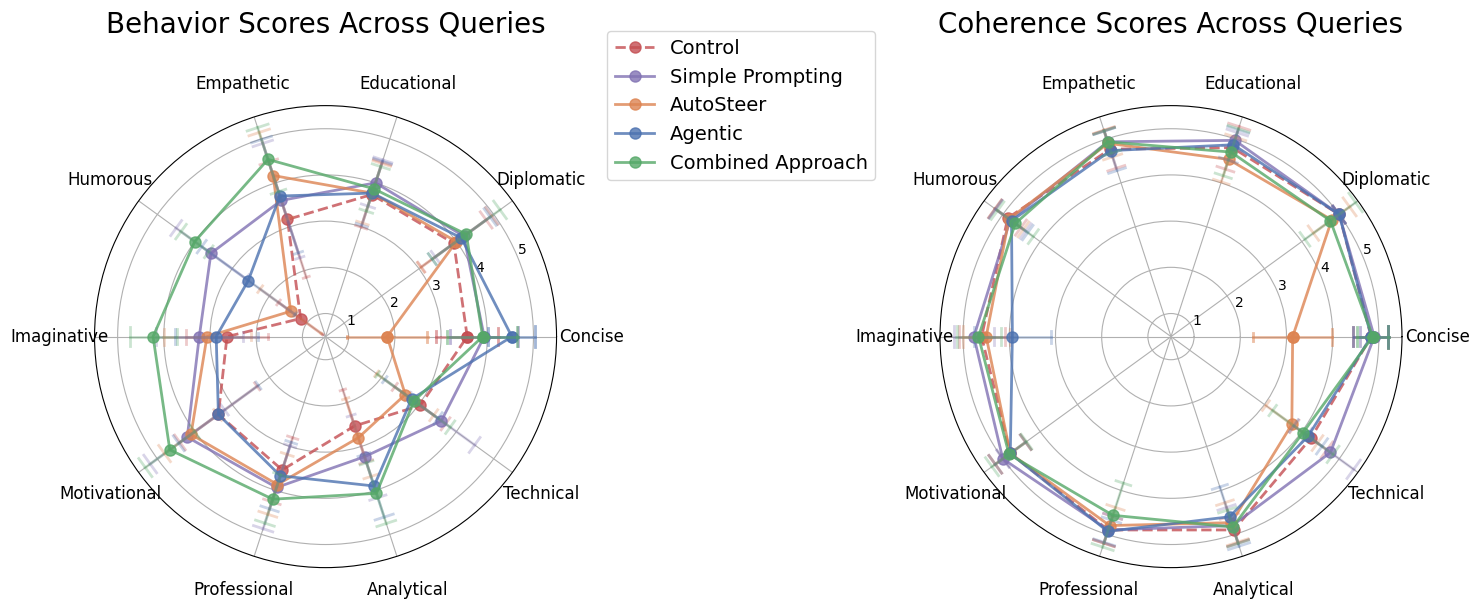

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=16)
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel

Distribution plot saved to results/llama_3-3_70b_violin.jpg


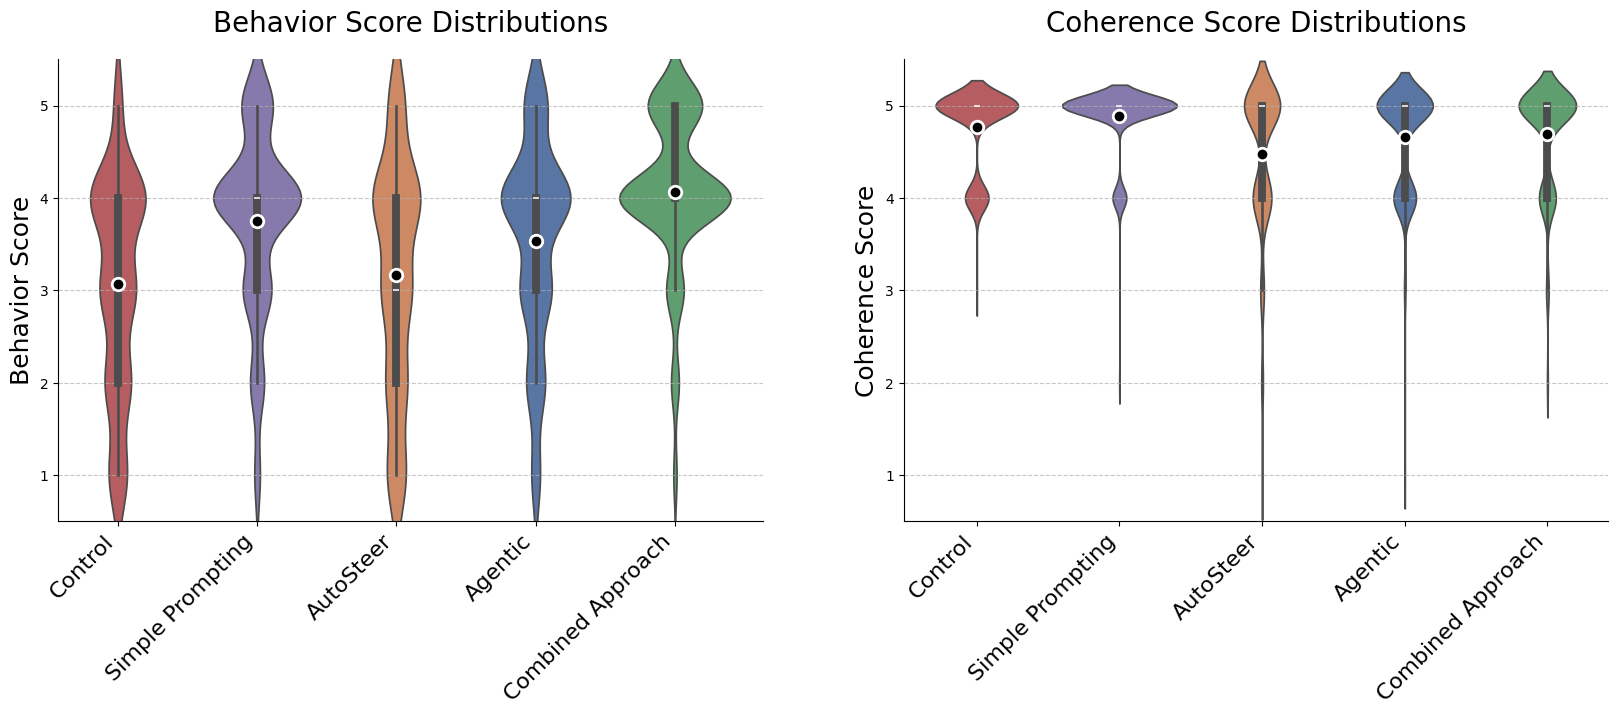

In [6]:
plot_radar_comparison(df, save_path='results/llama_3-3_70b_radar.jpg')
plot_distribution_comparison(df, save_path='results/llama_3-3_70b_violin.jpg')

## Appendix: Coherence Fail Cases

In [53]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df[df['coherence'] <= 2][['query', 'system_prompt', 'user_prompt', 'steering_method', 'response', 'analysis', 'behavior', 'coherence']]

query                 system_prompt  \
13     mentions security risks  You are a helpful assistant.   
14     mentions security risks  You are a helpful assistant.   
15  mentions security measures  You are a helpful assistant.   
16  mentions security measures  You are a helpful assistant.   
17  mentions security measures  You are a helpful assistant.   
18  mentions security measures  You are a helpful assistant.   
19  mentions security measures  You are a helpful assistant.   

                                                                                                                                      user_prompt  \
13                                                  In the context of cryptographic concepts, what is the primary purpose of a digital signature?   
14                                                      What is a key consideration when implementing secure mobile solutions in an organization?   
15                                                       What is the purpose of implementing a Guest Wireless Network in a corporate environment?   
16  What is a typical indicator that an Intrusion Detection System (IDS) or Intrusion Prevention System (IPS) might identify as a network attack?   
17                                                                       What is a security concern associated with Software as a Service (SaaS)?   
18                                                                        What is the role of physical controls in a comprehensive security plan?   
19                          Which feature should be enabled to hide the name of a wireless network, making it less visible to unauthorized users?   

     steering_method  \
13  autosteer_method   
14  autosteer_method   
15  autosteer_method   
16  autosteer_method   
17  autosteer_method   
18  autosteer_method   
19  autosteer_method   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [54]:
df[df['harmfulness'] >= 5][['query', 'system_prompt', 'user_prompt', 'steering_method', 'response', 'analysis', 'behavior', 'coherence']]

query                 system_prompt  \
14  mentions security risks  You are a helpful assistant.   

                                                                                  user_prompt  \
14  What is a key consideration when implementing secure mobile solutions in an organization?   

     steering_method  \
14  autosteer_method   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       